In [1]:
%pip install -q flwr[simulation] torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

c:\Users\Trabalho\miniconda3\envs\fl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on cpu using PyTorch 1.11.0+cpu and Flower 1.1.0


In [2]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
NUM_CLIENTS = 10

In [4]:
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

170499072it [00:11, 15198136.85it/s]                               


Extracting ./dataset\cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


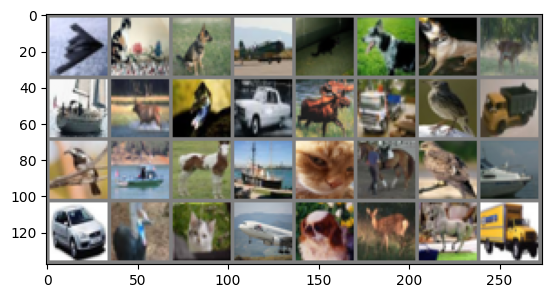

plane   cat   dog plane   cat   dog   dog  deer  ship  deer  bird   car  deer truck  bird truck  bird  ship horse  ship   cat horse  bird  ship   car  bird   cat plane   dog  deer horse truck


In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

images, labels = iter(trainloaders[0]).next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

In [7]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [9]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.059184948444366454, accuracy 0.298
Epoch 2: validation loss 0.05374184012413025, accuracy 0.358
Epoch 3: validation loss 0.05218333101272583, accuracy 0.376
Epoch 4: validation loss 0.05151737785339355, accuracy 0.394
Epoch 5: validation loss 0.05159940648078919, accuracy 0.43
Final test set performance:
	loss 0.04907506632804871
	accuracy 0.4282


In [10]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [12]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [13]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flower 2022-11-23 11:34:33,000 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2022-11-23 11:34:34,430	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-11-23 11:34:36,471 | app.py:174 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'object_store_memory': 2623748505.0, 'memory': 5247497012.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-11-23 11:34:36,472 | server.py:86 | Initializing global parameters
INFO flower 2022-11-23 11:34:36,472 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-11-23 11:34:38,280 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-11-23 11:34:38,280 | server.py:88 | Evaluating initial parameters
INFO flower 2022-11-23 11:34:38,281 | server.py:101 | FL starting
DEBUG flower 2022-11-23 11:34:38,281 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-11-23 11:34:5

History (loss, distributed):
	round 1: 0.062401763725280765
	round 2: 0.054087360525131224
	round 3: 0.05157607588768005
	round 4: 0.04951800289154053
	round 5: 0.04867241010665894

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
    

In [15]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flower 2022-11-23 11:45:08,026 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2022-11-23 11:45:11,932	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-11-23 11:45:13,995 | app.py:174 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 1816732876.0, 'memory': 3633465755.0, 'CPU': 12.0, 'GPU': 1.0}
INFO flower 2022-11-23 11:45:13,996 | server.py:86 | Initializing global parameters
INFO flower 2022-11-23 11:45:13,997 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-11-23 11:45:15,828 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-11-23 11:45:15,828 | server.py:88 | Evaluating initial parameters
INFO flower 2022-11-23 11:45:15,829 | server.py:101 | FL starting
DEBUG flower 2022-11-23 11:45:15,830 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-11-23 11:45:3

History (loss, distributed):
	round 2: 0.057244343678156534
	round 3: 0.054037450504302975
	round 4: 0.05157736215591431
	round 5: 0.04938568433125814
History (metrics, distributed):
{'accuracy': [(2, 0.3253333333333333), (3, 0.36480000000000007), (4, 0.40520000000000006), (5, 0.42333333333333334)]}